# Predicting QB Pressure Pre-Snap

Undergraduate Track (University of Florida) | By: John Crawford, Aaron Shumer, Jennifer Moloney, Bryson McGinley 

# Introduction
Pressure on the quarterback can make or break a play in football, and the foundation for applying this pressure is set before the ball is snapped. While much attention has been given to analyzing pressure dynamics during plays, the critical pre-snap phase remains largely untapped. This project explores the strategic elements that unfold before the snap, aiming to predict whether significant pressure will be applied to the quarterback using only information available before the snap. Using this model, we aim to understand what features are the most predictive of pressure on a play, to provide insights to defensive coaches and enable more pressures based solely on player positioning, independent of personnel. 

# Model
We trained an XGBoost Binary Classifier to predict whether or not there will be significant pressure on the Quarterback (QB) during a play, using pre-snap information regarding team formations and individual players. XGBoost was chosen due to its efficiency, ability to capture non-linear effects, and ease of dealing with an unbalanced classification problem such as this. Weeks 1-7 were used to train the model, and then testing was done with Weeks 8 and 9.

# Data Imbalance and filtering
It should be noted that the proportion of non-pressured to pressure plays is quite low, at only ~30% of plays. To help combat this, we tuned our classifier to treat each instance of pressure with double the weight as those cases without. 

Additionally, we filtered out all rush plays and plays where the quarterback held the ball for more than 4 seconds. Rush plays were excluded because they inherently do not involve quarterback pressure, as the focus is on running the ball. Plays where the quarterback holds the ball for more than 4 seconds were removed to avoid scenarios where pressure is not caused from initial positioning and scheme, which is the focus of this project. As illustrated in Figure 1, the majority of plays have a “time to throw” of less than 4 seconds, where longer plays represent a small fraction of the dataset. These longer plays were deemed outliers and excluded to ensure the model focused on the most relevant scenarios.


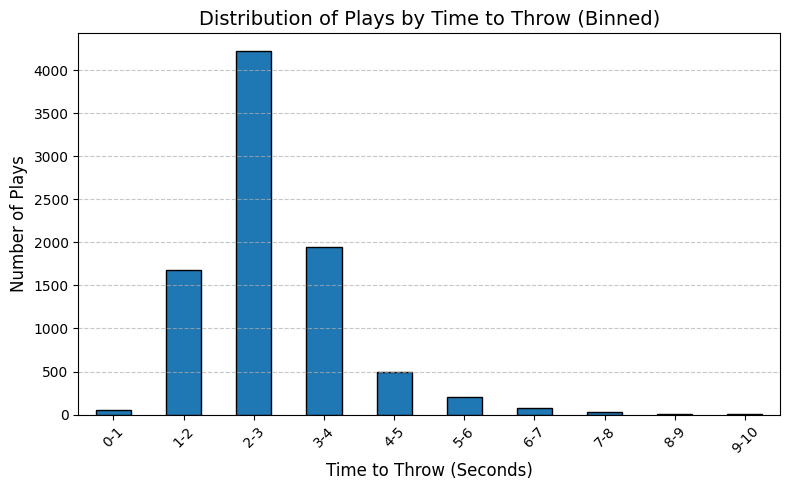

<center>
Figure 1: Distribution of plays based on QB’s Time to Throw Ball
</center>

# Feature Engineering

The following is a list of features we hypothesize have an effect of whether a passing play will lead to the quarterback being pressured or not.

1. Whether it is a critical down (3rd or 4th)
2. Whether it is a two-minute drill (last two minutes of 2nd or 4th quarter)
3. Average yards to go per remaining down for a first down
4. Expected Points on the play
5. Current Historical QB Pressure Rate
6. Maximum Gap Influence
7. Maximum Distance of any Defensive Lineman to closest Offensive Lineman
8. Max Defense Distance from Line
9. Average Defense Distance from Line
10. Defensive Line Spread

Features 1-4 capture game-state factors that influence the likelihood of pressure. Two-minute drills (2) and critical downs (1), for example, are relevant because these are situations where teams may have to be more aggressive with their plays. As a result, quarterbacks may need to throw the ball further downfield, spending more time in the pocket and increasing the likelihood of pressure. A similar effect is expected to be found with the average yards to go feature (3). Including expected points (4) is meant to capture specific game scenarios. For example, if a team is close to the goal line, they may be more likely to make quick passes. We expect that higher expected point plays would have less pressure and lower expected point plays would have more pressure.

Current Historical QB Pressure Rate (5) is a dynamically updated metric which divides the number of pressures that the quarterback encounters over the total number of plays the quarterback has been a part of. To prevent data leakage when training, each quarterback starts out with a blank slate, and these pressure rates are dynamically updated as a quarterback receives more snaps. However, to counteract the unstable pressure rates due to small sample sizes, each pressure rate is shrunk using the beta-binomial distribution. This adds around ~20 pressures and ~60 overall snaps to each quarterback, which pulls their rates closer to the overall average of plays. This simulates pressure around 30%. 20 pressures and 60 plays were chosen based on optimizing these parameters on the log-likelihood of the beta-binomial distribution using all data. This ensures stable estimates when limited data is available. 

Features 6-10 are all engineered features from the tracking data. The Max Gap Influence utilizes a Gaussian influence model, where a 2D Gaussian is applied to each defensive lineman pre-snap. The cumulative influence of all players is then calculated for each gap, with gap coordinates determined by the midpoints between adjacent linemen. The offensive line is a ‘weak-link’ system, meaning that it only takes one failure to allow the pressure. Because of this, we took the maximum influence on any of the gaps as a feature to predict pressure.

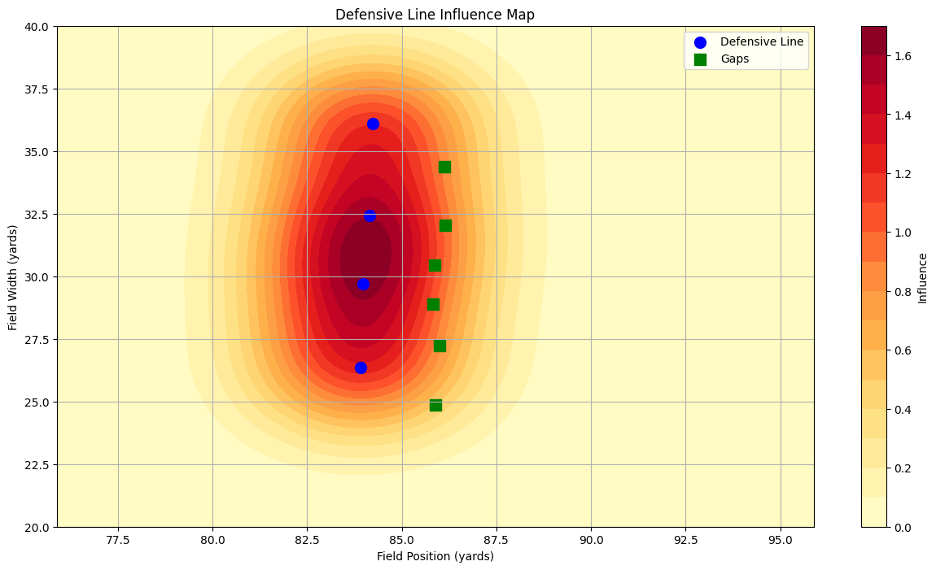

<center>
    Figure 2: Example of Gap Influence Model

</center>

The ‘maximum distance to offense' feature also utilizes this ‘weak-link’ system to its advantage, finding the maximum distance between each defensive lineman to the nearest offensive lineman. We theorize that if a defensive lineman’s nearest offensive lineman is farther away, it provides them with a better path to the quarterback and/or more time to accelerate.

To capture features dictated by the defensive scheme without using the “ground truth” (since we wouldn’t necessarily know this pre-snap), we included the average distance from all the defenders to the line of scrimmage and maximum distance from any one defender to the line of scrimmage. These features provide insight into how close the defense is to the line of scrimmage. We theorize that if defenders are closer to the line of scrimmage, there is a higher chance of a blitz and therefore a higher chance to generate pressure.

Defensive line spread takes the difference between the outermost defensive lineman, filtering out defensive backs and only counting players on the defensive line if they are within 2 yards of the line of scrimmage. We hypothesize that a greater spread on the line will generate more pressure due to the pressure coming from more angles. A greater spread on the line can indicate that the defense is not playing the run as much as the pass.


# Performance

As previously mentioned, the XGBoost Classifier was trained on Weeks 1-7 of the 2022 regular season data. The hyperparameters of the model were tuned using RandomizedSearchCV, which ensured optimal performance for our training set. Using this tuning, alongside three-fold cross validation and a scaling weight parameter (emphasizing priority of the minority class), an unbiased classification model was created. 

With the optimal hyperparameters, the model ran with an F1 score of 0.43, indicating that less than half of the predictions for the positive class (that there was a pressure) were true values. The model’s AUC was 0.566, which suggests a slightly better classification method than random guessing. 

Looking at Figure 3, we can observe that the model tends to over-predict the probability of a pressure, with almost all of the points falling below the perfect calibration curve. This bias is most likely due to the excess weight our model places on errors from the minority class- that there was a pressure on the play. This additional weight is still necessary, as without it, the model would predict no pressure almost every time. This is due to the lack of predictability discovered across features. The overall trend of the calibration curve is positive, which is a positive indicator. This suggests that the actual rate of pressures in the test set increases as our predicted probabilities do, even with this bias in mind.

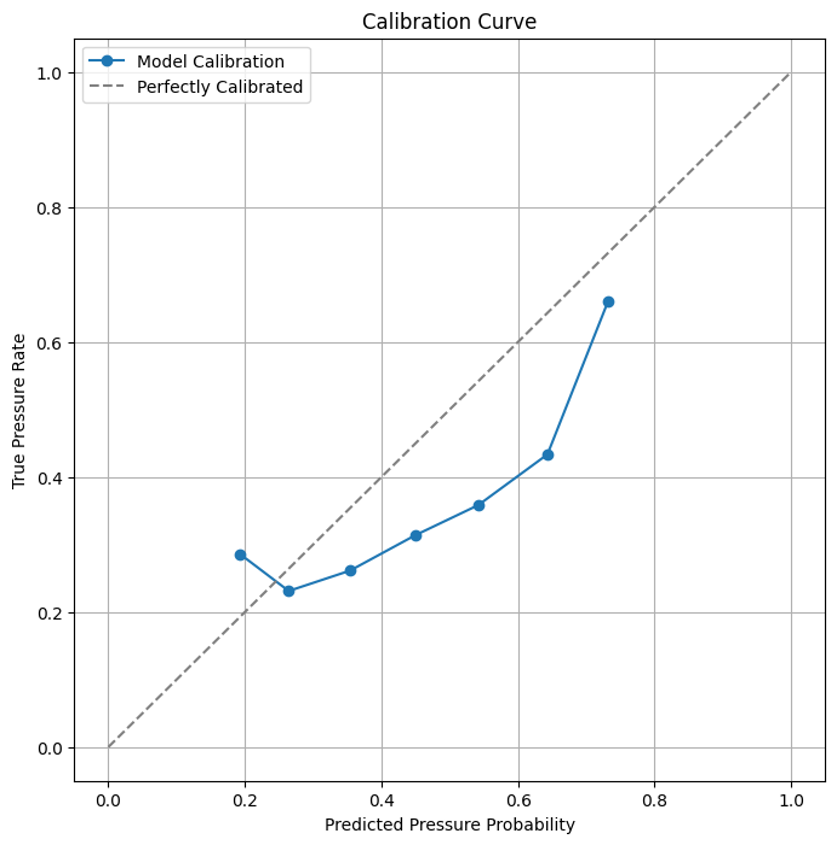

<center>
    Figure 3: Calibration Curve between predicted pressure probability and the pressure rate

</center>
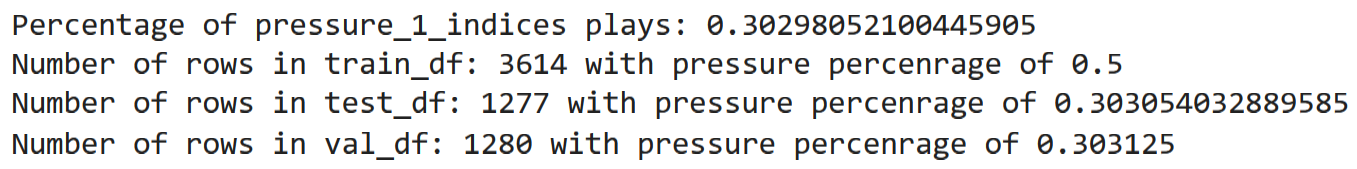

The SHapley Additive exPlanations, or SHAP values, in Figure 4 highlight the most influential factors in predicting whether the defense caused significant pressure on the QB during a play. The features are listed in order from top to bottom in influence. "Current_pressure_rate" is the most important feature, with higher values significantly increasing the likelihood of pressure. This suggests that pressure on any given play is highly related to the ability of the offense, namely the ability of a quarterback to avoid pressure, or quality of the offensive line.  "Critical_down" also plays a vital role, suggesting that high-leverage situations, like third or fourth downs, strongly contribute to defensive pressure. Tracking data features like "max_gap_influence" and "max_distance_to_offense" show that defensive line alignment in relation to the offensive line is also significant for determining pressure on the play. On the other hand, features like "two_minute_drill" and "dlinespread" have less influence, indicating that situational factors like the game clock or defensive line spread are less impactful in this context. Overall, the plot underscores that the defense's prior performance and alignment relative to offensive positioning are the primary drivers of QB pressure.

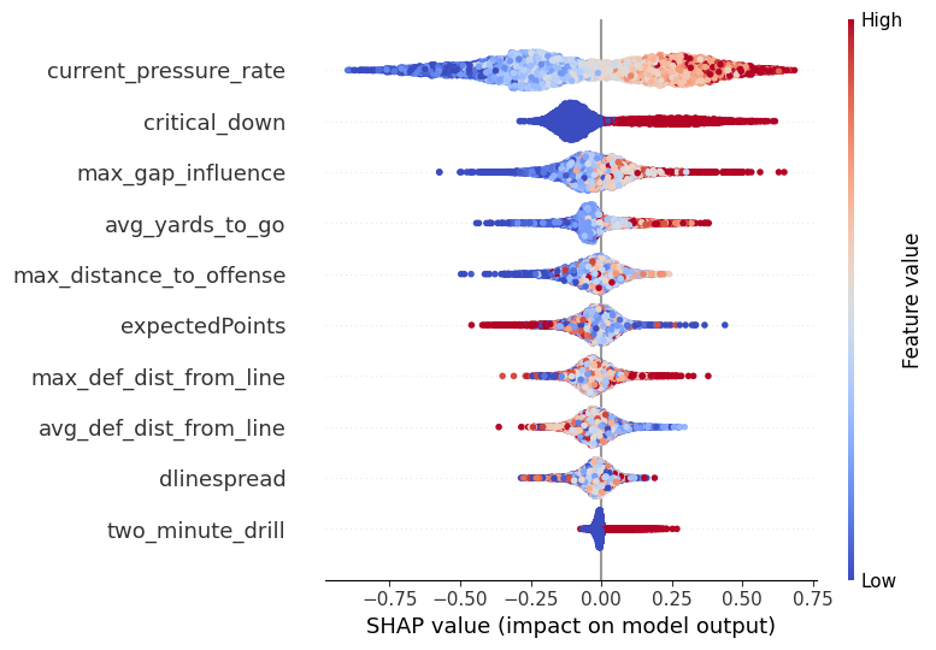

<center>
    Figure 4: SHAP values of each feature
</center>
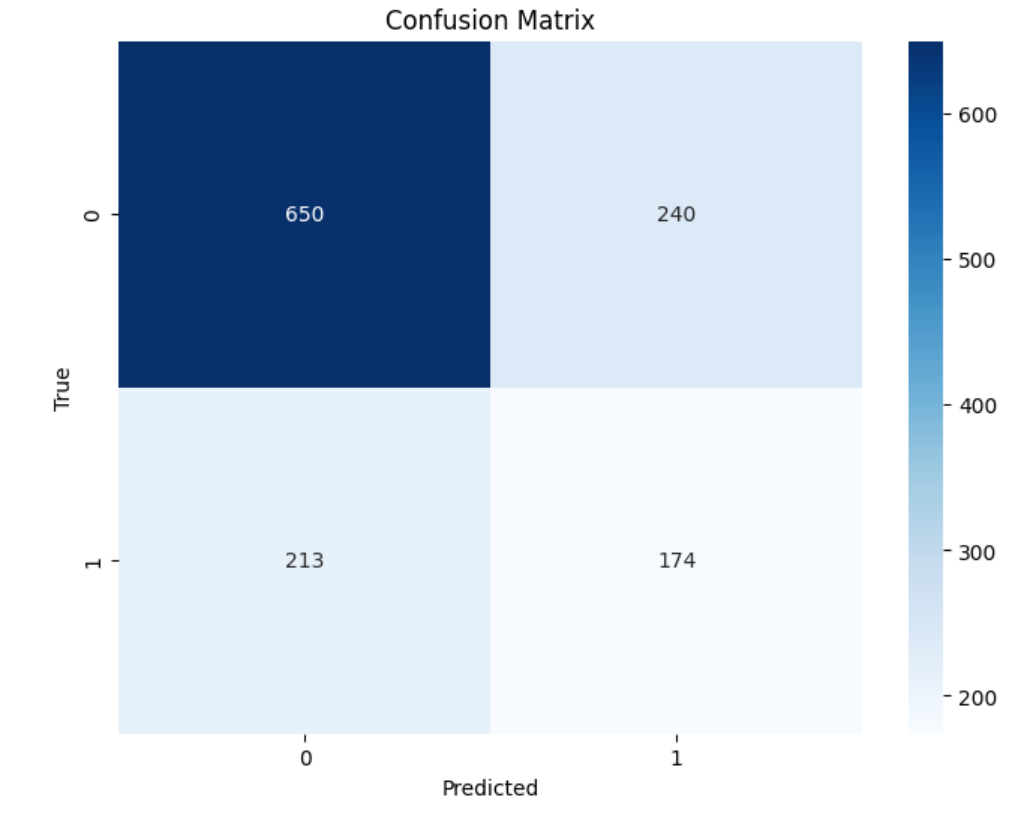

A good feature should have blue and red dots on the above plot split well, indicating good discrimination between the classes. While “current_pressure_rate” and “critical_down” distinguish the classes very well, other tracking data features, such as the defensive line spread and max distance from a defender to the line, have a max of red (high value) and blue (low value) scattered throughout the x-axis, suggesting that these features aren’t as predictive. The SHAP plot indicates that most of these features have the effects we hypothesized on predicting pressure on a given play. One of the main differences is that a higher “max_distance_to_offense” leads to a higher-pressure probability in the model, which is the opposite of what we hypothesized. This suggests that coverage schemes with deeper safeties tend to generate more pressures, which should be explored further. Also, we find that “max_distance_to_offense” mostly affects the prediction of the model with its low values, predicting less pressure when this is the case. However, this was not found for the opposite scenario. 

An example of a high gap influence leading to a pressure can be found in Figure 5, where a max gap influence of 1.91 is applied on the gap between the center and the right guard, which is a 98th percentile value. This disruption near the interior of the line leads to an easy lane for a stunt move by an edge rusher to push through the gap and pressure Kirk Cousins leading him to throw the ball slightly earlier than he wanted to on a comeback route to Adam Thielen.

![Play GIF](https://i.imgur.com/fII4B9g.gif)

<center>
    Figure 5: High Gap Influence Play
</center>
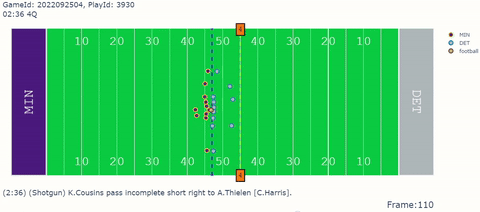

# Conclusion

In conclusion, this project highlights the potential of using pre-snap information to predict quarterback pressure, but also underscores the challenges in achieving consistent performance. While the model provides insights into key factors like gap influence and distances between lineman, its modest F1 score indicates that predicting pressure solely before the snap remains a complex task. The imbalance in the data and the inherent unpredictability of football plays make this a difficult problem to solve with high accuracy.

Future improvements to the model would mainly come through discovering/creating more predictive features. All the features in this model deal with the frame directly before the snap, and patterns of movement in all frames before the snap could be analyzed. Individual pass rusher skill was not factored into this model, as we wanted to identify scheme effects independent of personnel ability, but this could be added to the model to improve predictability. It is also worth looking into defensive lineman switching positions on the line before the snap and whether that has success in generating pressure.

# Code and Appendix:

GitHub: https://github.com/CrawfordJohn/big-data-bowl

Thank you to Nick Wan for the code for the play dots in Figure 5: https://www.kaggle.com/code/nickwan/animate-plays-with-plotly-real-no-lies-here
